In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, TensorDataset

%matplotlib inline

In [2]:
np.random.seed(42)
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

## Data visualization

In [3]:
data = pd.read_csv('data.csv',parse_dates = True, index_col=0)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-08-09,14.250000,16.750000,14.250000,16.500000,14.892752,1601500
1996-08-12,16.500000,16.750000,16.375000,16.500000,14.892752,260900
1996-08-13,16.500000,16.750000,16.375000,16.375000,14.779927,162800
1996-08-14,16.375000,16.625000,16.375000,16.375000,14.779927,59500
1996-08-15,16.625000,16.625000,16.375000,16.625000,15.005575,62300
...,...,...,...,...,...,...
2021-04-01,35.270000,36.340000,35.099998,36.139999,36.139999,111400
2021-04-05,36.580002,36.849998,36.200001,36.529999,36.529999,114000
2021-04-06,36.650002,36.930000,36.349998,36.660000,36.660000,66100


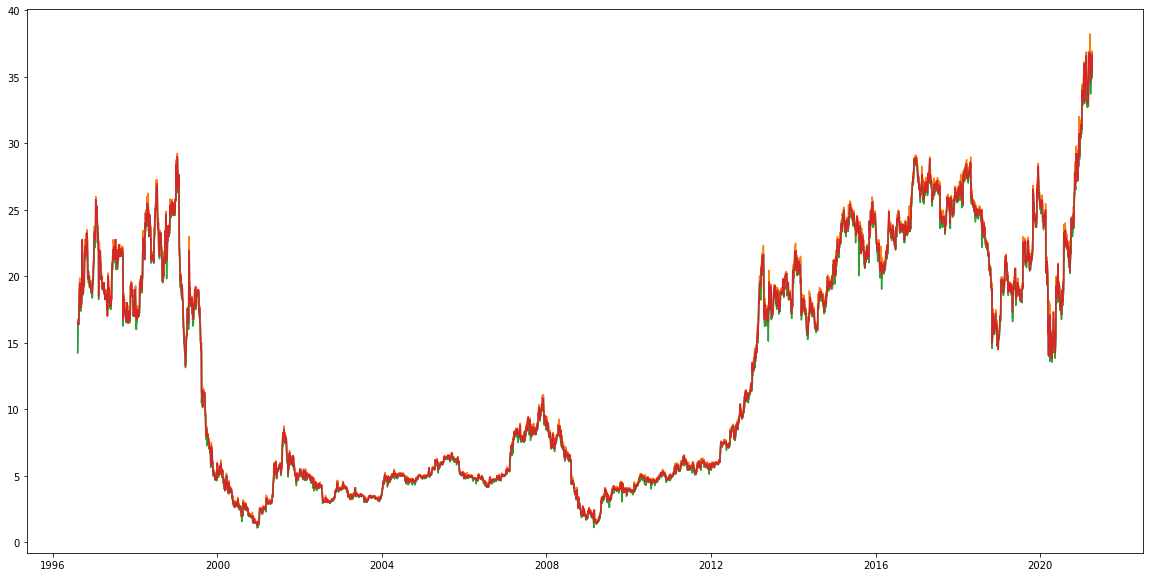

In [4]:
plt.figure(figsize=(20,10))
plt.plot(data['Open'])
plt.plot(data['High'])
plt.plot(data['Low'])
plt.plot(data['Close'])

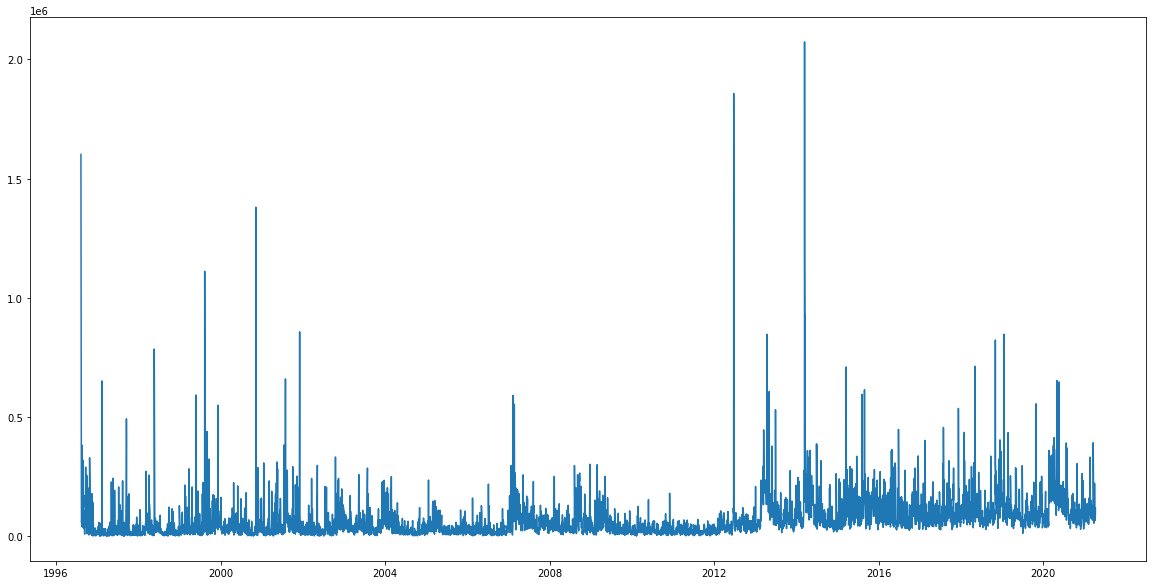

In [5]:
plt.figure(figsize=(20, 10))
plt.plot(data['Volume'])

## data split

In [8]:
data = data[['Close', 'Open', 'High', 'Low', 'Volume']]
print(data)
train_start = dt.date(1996,8,9)
train_end = dt.date(2011,12,31)
train_data = data.loc[train_start:train_end]

val_start = dt.date(2012,1,1)
val_end = dt.date(2016,12,31)
val_data = data.loc[val_start:val_end]

test_start = dt.date(2016,1,1)
test_end = dt.date(2020,4,7)
test_data = data.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

                Close       Open       High        Low   Volume
Date                                                           
1996-08-09  16.500000  14.250000  16.750000  14.250000  1601500
1996-08-12  16.500000  16.500000  16.750000  16.375000   260900
1996-08-13  16.375000  16.500000  16.750000  16.375000   162800
1996-08-14  16.375000  16.375000  16.625000  16.375000    59500
1996-08-15  16.625000  16.625000  16.625000  16.375000    62300
...               ...        ...        ...        ...      ...
2021-04-01  36.139999  35.270000  36.340000  35.099998   111400
2021-04-05  36.529999  36.580002  36.849998  36.200001   114000
2021-04-06  36.660000  36.650002  36.930000  36.349998    66100
2021-04-07  35.759998  36.549999  36.680000  35.570000    83300
2021-04-08  35.320000  35.750000  35.790001  34.910000   116200

[6207 rows x 5 columns]
(3876, 5) (1258, 5) (1073, 5)


## Scaling

In [9]:
sc = StandardScaler()
train = sc.fit_transform(train_data)
val = sc.fit_transform(val_data)
test = sc.fit_transform(test_data)

## torch dataset

In [10]:
def convert2torch(data, time_step):
    X_data, y_data = list(), list()
    for i in range(time_step, len(data)):
        X_data.append(data[i-time_step:i])
        y_data.append(data[i][0])
    X_data, y_data = torch.Tensor(X_data), torch.Tensor(y_data)
    return X_data, y_data

In [11]:
batch_size = 128

X_train, y_train = convert2torch(train, 50)
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

X_val, y_val = convert2torch(val, 50)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

X_test, y_test = convert2torch(test, 50)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

## Model

In [12]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MultivariateLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, self.hidden_dim, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2000, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 32)
        self.fc6 = nn.Linear(32, 1)
        
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(32)
        self.act = nn.ReLU()
    def forward(self, inp):
        h0, c0 = self.init_hidden(inp)
        output, (h_t, c_t) = self.lstm(inp, (h0, c0))
        output = self.flatten(output)
        output = self.act(self.bn1(self.fc1(output)))
        output = self.act(self.bn2(self.fc2(output)))
        output = self.act(self.bn3(self.fc3(output)))
        output = self.act(self.bn4(self.fc4(output)))
        output = self.act(self.bn5(self.fc5(output)))
        output = self.fc6(output)
        return output
        
    def init_hidden(self, inp):
        b, seq_len, c = inp.size()
        h0 = torch.zeros(1, b, self.hidden_dim)
        c0 = torch.zeros(1, b, self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [13]:
with torch.no_grad():
    dataiter = iter(train_loader)
    X, y = dataiter.next()
    print(X.shape)
    print(y.shape)
    model = MultivariateLSTM(5, 40).cuda()
    output = model(X.cuda())
    print(output.shape)
    print(output)
    criterion = nn.MSELoss()
    loss = criterion(output.squeeze(), y.cuda())

torch.Size([128, 50, 5])
torch.Size([128])
torch.Size([128, 1])
tensor([[-0.9329],
        [-0.5199],
        [ 0.1613],
        [-0.1401],
        [-0.6487],
        [-0.2604],
        [ 0.5294],
        [ 0.2653],
        [-0.1701],
        [ 0.0488],
        [ 0.1952],
        [-0.1957],
        [-0.3060],
        [-0.2737],
        [-0.2260],
        [-0.4145],
        [-0.1314],
        [-0.3874],
        [-0.4576],
        [-0.7434],
        [-0.6429],
        [-0.3689],
        [-0.0923],
        [-0.7248],
        [-0.5087],
        [-0.2656],
        [-0.5222],
        [-0.4203],
        [-0.4549],
        [-0.4882],
        [-0.3088],
        [-0.5727],
        [-0.1519],
        [-0.5552],
        [-0.5395],
        [-0.5475],
        [-0.2000],
        [-0.2664],
        [-0.4725],
        [-0.4083],
        [-0.8218],
        [-0.2944],
        [-0.6630],
        [-0.4697],
        [-0.3180],
        [-0.3744],
        [-0.3462],
        [-0.5113],
        [-0.7268],
     

## Train

In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='carr_ser_singleLSTM.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [15]:
model = MultivariateLSTM(5, 40).cuda()

lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       mode='min',
                                                       factor=0.2
                                                    )
criterion = nn.MSELoss().cuda()
patience = 20
n_epochs = 300

print(model)

MultivariateLSTM(
  (lstm): LSTM(5, 40, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
)


In [16]:
def fit(model, batch_size, patience, n_epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in val_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
            
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('carr_ser_singleLSTM.pth'))

    return  model, avg_train_losses, avg_valid_losses

In [17]:
def evaluate_model(model, test_loader):
    test_loss = 0.0
    y_test = []
    y_hat = []
    model.eval()
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        y_test.append(target.cpu().detach().numpy())
        output = model(data)
        y_hat.append(output.view(1).cpu().detach().numpy())
        loss = criterion(output.view(1), target)
        test_loss += loss.item()
    return test_loss/len(test_loader), y_test, y_hat

In [18]:
model, train_loss, valid_loss = fit(model, batch_size, patience, n_epochs)

[  1/300] train_loss: 1.21520 valid_loss: 1.07272
Validation loss decreased (inf --> 1.072722).  Saving model ...
[  2/300] train_loss: 1.08163 valid_loss: 0.22125
Validation loss decreased (1.072722 --> 0.221247).  Saving model ...
[  3/300] train_loss: 0.98179 valid_loss: 0.60108
EarlyStopping counter: 1 out of 20
[  4/300] train_loss: 0.91762 valid_loss: 1.46772
EarlyStopping counter: 2 out of 20
[  5/300] train_loss: 0.88057 valid_loss: 0.50155
EarlyStopping counter: 3 out of 20
[  6/300] train_loss: 0.84869 valid_loss: 1.90760
EarlyStopping counter: 4 out of 20
[  7/300] train_loss: 0.81707 valid_loss: 3.36404
EarlyStopping counter: 5 out of 20
[  8/300] train_loss: 0.79043 valid_loss: 1.07070
EarlyStopping counter: 6 out of 20
[  9/300] train_loss: 0.77410 valid_loss: 3.32994
EarlyStopping counter: 7 out of 20
[ 10/300] train_loss: 0.75127 valid_loss: 3.88688
EarlyStopping counter: 8 out of 20
[ 11/300] train_loss: 0.72465 valid_loss: 4.03455
EarlyStopping counter: 9 out of 20
[ 

In [14]:
model.load_state_dict(torch.load('carr_ser_singleLSTM.pth'))

<All keys matched successfully>

In [19]:
test_loss, y_test, y_hat = evaluate_model(model, test_loader)

In [22]:
test_loss

0.4399351284724508

In [49]:
y_test[0], y_hat[0]

(array([-1.343302], dtype=float32), array([-0.01452462], dtype=float32))

In [20]:
target, predicted = list(), list()
for i in range(len(y_test)):
    target.append(y_test[i].item())
    predicted.append(y_hat[i][0].item())

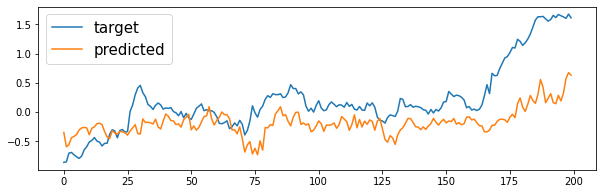

In [21]:
plt.figure(figsize=(10, 3))
plt.plot(target[:200], label='target')
plt.plot(predicted[:200], label='predicted')
plt.legend(loc='upper left', fontsize=15)
plt.show()

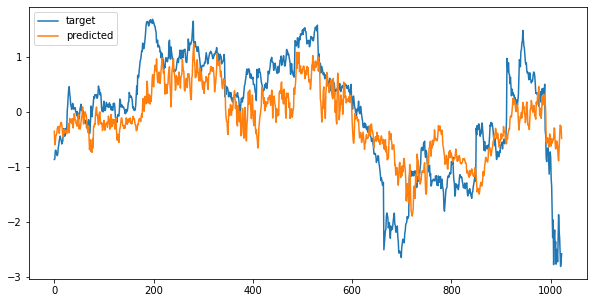

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(target, label='target')
plt.plot(predicted, label='predicted')
plt.legend()
plt.show()